# Baseline Modeling and Evaluation

This notebook builds **baseline machine learning models** to analyze and classify socio-economic data across different economies and years.  
The goal is to establish strong, interpretable baselines before experimenting with more advanced or specialized models.

### Key Steps
1. **Data Loading** — Import the cleaned dataset for further analysis.  
2. **Data Transformation** — Reshape the data into a structured format suitable for modeling (`(Economy, Year)` × Indicators).  
3. **Feature Scaling** — Normalize indicator values to ensure fair contribution across features.  
4. **Train-Test Split** — Divide the data to fairly evaluate model performance.  
5. **Model Training** — Build two baseline models:  
   - **Random Forest Classifier** for a tree-based ensemble approach.  
   - **MLP (Neural Network)** for a non-linear, feature-rich approach.  
6. **Model Evaluation** — Compare models using accuracy, F1-score, and confusion matrices to identify strengths and weaknesses.  
7. **Visualization** — Use UMAP and confusion matrices to interpret performance and understand data structure.  

### Outcome
By the end of this notebook, we identify which baseline model generalizes better, analyze class-wise prediction behavior, and outline directions for further model improvements.


In [819]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.metrics import silhouette_score

import umap
import networkx as nx
from node2vec import Node2Vec
import warnings
warnings.filterwarnings("ignore")

### Data Loading
Load the cleaned dataset into a pandas DataFrame. This step reads the preprocessed data file which will be used for analysis and modeling.

In [ ]:
# Load cleaned dataset
df = pd.read_csv('cleaned_final_dataset.csv')
print("Data loaded:", df.shape)
df.head()

Data loaded: (10984, 8)


,Economy,Indicator,Year,Value,Indicator_encoded,Economy_encoded,Indicator_group,Indicator_group_code
0,Brazil,Desktop computer,2014,28.2715,16,12,Device,0
1,Brazil,Laptop computer,2014,30.4960,41,12,Device,0
2,Brazil,Tablet,2014,16.5186,53,12,Device,0
3,Colombia,Desktop computer,2014,27.4837,16,19,Device,0
4,Colombia,Laptop computer,2014,24.2130,41,19,Device,0


### Data Transformation (Pivot Table)
Reshape the dataset so that each `(Economy, Year)` pair becomes one row, and each indicator forms a column. 

In [821]:
# Pivot: create (Economy, Year) × Indicators
df_features = df[['Economy', 'Year', 'Indicator', 'Value']].copy()

pivot_df = df_features.pivot_table(
    index=['Economy', 'Year'],
    columns='Indicator',
    values='Value',
    aggfunc='mean'
).reset_index()

print(f"Pivot table shape: {pivot_df.shape}")
print(f"Unique countries: {pivot_df['Economy'].nunique()}")
print(f"Years range: {pivot_df['Year'].min()} - {pivot_df['Year'].max()}")

# Handle missing values
pivot_df = pivot_df.fillna(pivot_df.mean(numeric_only=True))
pivot_df.head()

Pivot table shape: (734, 63)
Unique countries: 99
Years range: 2014 - 2024


Indicator,Economy,Year,By broadband,By fixed (wired) broadband,By fixed broadband and mobile broadband network,By fixed broadband network only,By fixed narrowband network,By mobile broadband network only,By mobile broadband network via a card or USB modem,By mobile broadband network via a handset,...,Setting up effective security measures to protect devices and accounts,Software excluding games and computer software packages,Tablet,Taking part in online consultations or voting to define civic or political issues,Transferring files between a computer and other devices,Using basic arithmetic formula in a spreadsheet,Using copy and paste tools within a document,"Using software run over the Internet for editing text documents, spreadsheets or presentations",Verifying the reliability of information found online,Writing a computer program using a programming language
0,Albania,2019,82.1956,56.896632,37.4364,9.112720,2.449763,35.64650,7.481435,51.628814,...,42.020273,0.153916,33.185047,8.963941,19.9906,34.358638,16.1205,13.36641,31.656678,1.56061
1,Albania,2020,83.2799,56.896632,49.4303,7.757850,2.449763,26.09170,7.481435,51.628814,...,42.020273,0.153916,33.185047,8.963941,25.0233,34.358638,19.2036,13.36641,31.656678,3.67419
2,Albania,2021,88.2611,56.896632,68.3022,0.819426,2.449763,19.13930,7.481435,51.628814,...,42.020273,0.153916,33.185047,8.963941,31.5460,34.358638,22.0341,13.36641,7.907900,5.65271
3,Albania,2022,96.5041,56.896632,86.3927,0.782390,2.449763,9.32901,7.481435,51.628814,...,42.020273,0.153916,33.185047,8.963941,35.9182,34.358638,26.7801,13.36641,6.282750,6.58558
4,Albania,2023,96.7130,56.896632,86.8086,0.661782,2.449763,9.24264,7.481435,51.628814,...,42.020273,0.153916,33.185047,8.963941,37.5419,34.358638,28.9158,13.36641,12.823800,6.92073


### Feature Scaling
Normalize or standardize the feature values to ensure all indicators contribute equally to the model. 

In [822]:
# PCA: build embeddings
features = pivot_df.drop(columns=['Economy', 'Year'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca = PCA(n_components=40, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

pca_cols = [f'pca_{i}' for i in range(32)]
for i, col in enumerate(pca_cols):
    pivot_df[col] = X_pca[:, i]

pivot_df.head()

PCA explained variance: 95.48%


Indicator,Economy,Year,By broadband,By fixed (wired) broadband,By fixed broadband and mobile broadband network,By fixed broadband network only,By fixed narrowband network,By mobile broadband network only,By mobile broadband network via a card or USB modem,By mobile broadband network via a handset,...,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31
0,Albania,2019,82.1956,56.896632,37.4364,9.112720,2.449763,35.64650,7.481435,51.628814,...,-0.571761,0.434732,0.052196,0.660265,0.234327,0.202152,-0.054437,0.798405,-0.596405,-0.783896
1,Albania,2020,83.2799,56.896632,49.4303,7.757850,2.449763,26.09170,7.481435,51.628814,...,-1.197899,1.523904,-0.922004,0.659258,-0.213830,0.355174,0.026162,1.905190,-0.291635,0.004018
2,Albania,2021,88.2611,56.896632,68.3022,0.819426,2.449763,19.13930,7.481435,51.628814,...,-0.314316,0.455427,-1.538914,0.244522,-0.886524,-0.974080,-0.765225,1.580843,-0.626787,-0.537003
3,Albania,2022,96.5041,56.896632,86.3927,0.782390,2.449763,9.32901,7.481435,51.628814,...,0.341223,-0.405479,-1.859376,-0.086844,-1.050349,-1.907090,-0.419985,1.422964,-0.385697,-0.409190
4,Albania,2023,96.7130,56.896632,86.8086,0.661782,2.449763,9.24264,7.481435,51.628814,...,0.542555,-0.517837,-2.091376,-0.086739,-1.325962,-0.912040,-0.810349,1.183174,-0.593701,-0.259697


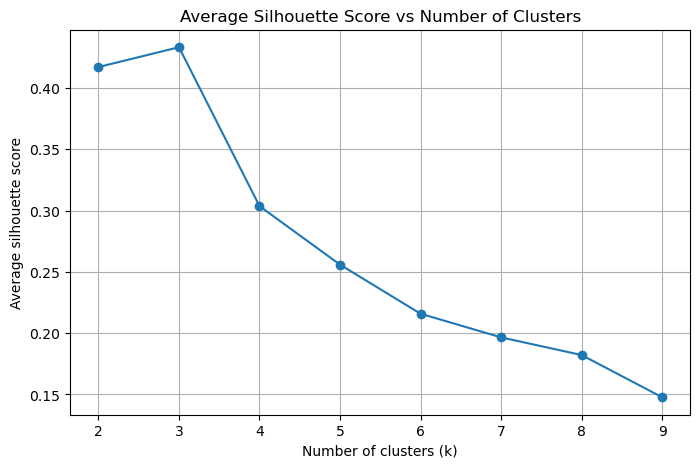

Best number of clusters based on silhouette score: 3


In [ ]:
possible_k = range(2, 10)
silhouette_scores = []

for k in possible_k:
    scores_per_year = []
    for year in sorted(pivot_df['Year'].unique()):
        subset = pivot_df[pivot_df['Year'] == year][pca_cols]
        if len(subset) > k:  # at least as many samples as clusters
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(subset)
            score = silhouette_score(subset, labels)
            scores_per_year.append(score)
    if scores_per_year:
        silhouette_scores.append(np.mean(scores_per_year))
    else:
        silhouette_scores.append(np.nan)

plt.figure(figsize=(8, 5))
plt.plot(possible_k, silhouette_scores, marker='o')
plt.title("Average Silhouette Score vs Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average silhouette score")
plt.grid(True)
plt.show()

best_k = possible_k[np.nanargmax(silhouette_scores)]
print(f"Best number of clusters based on silhouette score: {best_k}")

In [824]:
# Clustering countries by year
N_CLUSTERS = best_k
pivot_df['cluster'] = None

for year in sorted(pivot_df['Year'].unique()):
    subset = pivot_df[pivot_df['Year'] == year]
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
    pivot_df.loc[subset.index, 'cluster'] = kmeans.fit_predict(subset[pca_cols])

pivot_df['cluster'] = pivot_df['cluster'].astype(int)
pivot_df.head()

Indicator,Economy,Year,By broadband,By fixed (wired) broadband,By fixed broadband and mobile broadband network,By fixed broadband network only,By fixed narrowband network,By mobile broadband network only,By mobile broadband network via a card or USB modem,By mobile broadband network via a handset,...,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,cluster
0,Albania,2019,82.1956,56.896632,37.4364,9.112720,2.449763,35.64650,7.481435,51.628814,...,0.434732,0.052196,0.660265,0.234327,0.202152,-0.054437,0.798405,-0.596405,-0.783896,1
1,Albania,2020,83.2799,56.896632,49.4303,7.757850,2.449763,26.09170,7.481435,51.628814,...,1.523904,-0.922004,0.659258,-0.213830,0.355174,0.026162,1.905190,-0.291635,0.004018,0
2,Albania,2021,88.2611,56.896632,68.3022,0.819426,2.449763,19.13930,7.481435,51.628814,...,0.455427,-1.538914,0.244522,-0.886524,-0.974080,-0.765225,1.580843,-0.626787,-0.537003,0
3,Albania,2022,96.5041,56.896632,86.3927,0.782390,2.449763,9.32901,7.481435,51.628814,...,-0.405479,-1.859376,-0.086844,-1.050349,-1.907090,-0.419985,1.422964,-0.385697,-0.409190,0
4,Albania,2023,96.7130,56.896632,86.8086,0.661782,2.449763,9.24264,7.481435,51.628814,...,-0.517837,-2.091376,-0.086739,-1.325962,-0.912040,-0.810349,1.183174,-0.593701,-0.259697,0


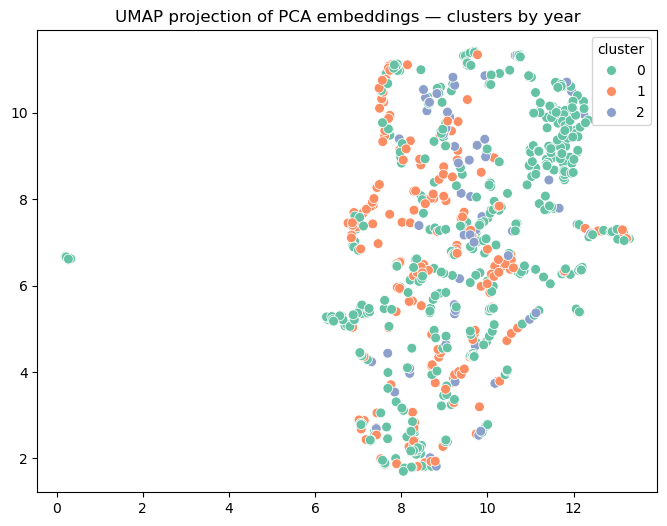

In [825]:
# Visualize PCA embeddings (UMAP projection)
reducer = umap.UMAP(random_state=42)
Z = reducer.fit_transform(pivot_df[pca_cols])

plt.figure(figsize=(8,6))
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=pivot_df['cluster'], palette='Set2', s=50)
plt.title("UMAP projection of PCA embeddings — clusters by year")
plt.show()

In [826]:
# Create target: cluster next year
pivot_df = pivot_df.sort_values(['Economy', 'Year'])
pivot_df['next_cluster'] = pivot_df.groupby('Economy')['cluster'].shift(-1)
pivot_df = pivot_df.dropna(subset=['next_cluster'])
pivot_df['next_cluster'] = pivot_df['next_cluster'].astype(int)

print("Data with target:", pivot_df.shape)
pivot_df[['Economy', 'Year', 'cluster', 'next_cluster']].head(10)

Data with target: (635, 97)


Indicator,Economy,Year,cluster,next_cluster
0,Albania,2019,1,0
1,Albania,2020,0,0
2,Albania,2021,0,0
3,Albania,2022,0,0
6,Armenia,2019,2,0
7,Armenia,2020,0,0
8,Armenia,2021,0,0
9,Armenia,2022,0,0
11,Austria,2014,0,1
12,Austria,2015,1,1


### Train-Test Split
Split the dataset into training and testing subsets to evaluate model performance on unseen data.

In [827]:
# Prepare X, y for prediction
X = pivot_df[pca_cols + ['cluster']]
y = pivot_df['next_cluster']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/Test:", X_train.shape, X_test.shape)

Train/Test: (508, 33) (127, 33)


### Baseline Model: Random Forest
Train a Random Forest classifier as a baseline model. This helps evaluate how well a tree-based ensemble method can predict the target variable.

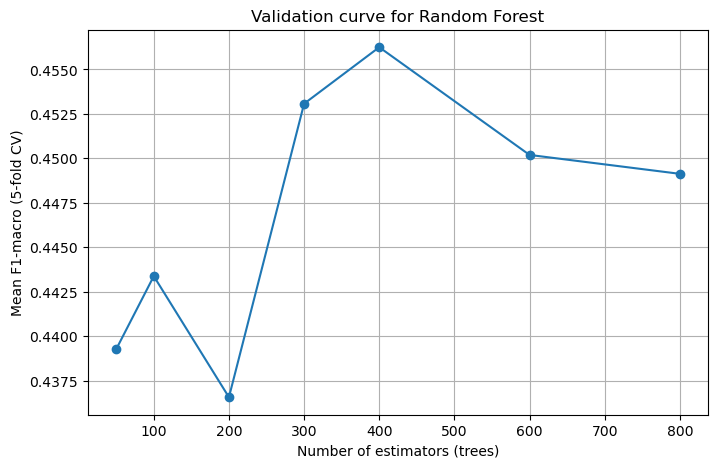

Best n_estimators: 400


In [828]:
n_estimators_range = [50, 100, 200, 300, 400, 600, 800]
scores = []

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    # 5-fold cross-validation for robust estimate
    cv_score = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_macro').mean()
    scores.append(cv_score)

plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, scores, marker='o')
plt.title("Validation curve for Random Forest")
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Mean F1-macro (5-fold CV)")
plt.grid(True)
plt.show()

best_n = n_estimators_range[np.argmax(scores)]
print(f"Best n_estimators: {best_n}")

In [829]:
# Baseline 1: Random Forest
rf = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("=== Random Forest Results ===")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf, average='macro'))

=== Random Forest Results ===
              precision    recall  f1-score   support

           0       0.72      0.89      0.80        75
           1       0.69      0.58      0.63        38
           2       0.50      0.07      0.12        14

    accuracy                           0.71       127
   macro avg       0.64      0.51      0.52       127
weighted avg       0.69      0.71      0.67       127

Accuracy: 0.7086614173228346
F1: 0.5170634920634921


### Baseline Model: Neural Network (MLP)
Train a Multi-Layer Perceptron classifier to compare its performance with the Random Forest. This provides insight into how non-linear models perform on the same data.

In [830]:
# Baseline 2: MLP
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=400, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("=== MLP Results ===")
print(classification_report(y_test, y_pred_mlp))
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("F1:", f1_score(y_test, y_pred_mlp, average='macro'))

=== MLP Results ===
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        75
           1       0.63      0.76      0.69        38
           2       0.40      0.29      0.33        14

    accuracy                           0.71       127
   macro avg       0.61      0.60      0.60       127
weighted avg       0.71      0.71      0.70       127

Accuracy: 0.7086614173228346
F1: 0.6015438138725809


### Confusion Matrix Visualization
Visualize the confusion matrix to understand which classes are often misclassified. Helps to see potential model weaknesses or class imbalance.

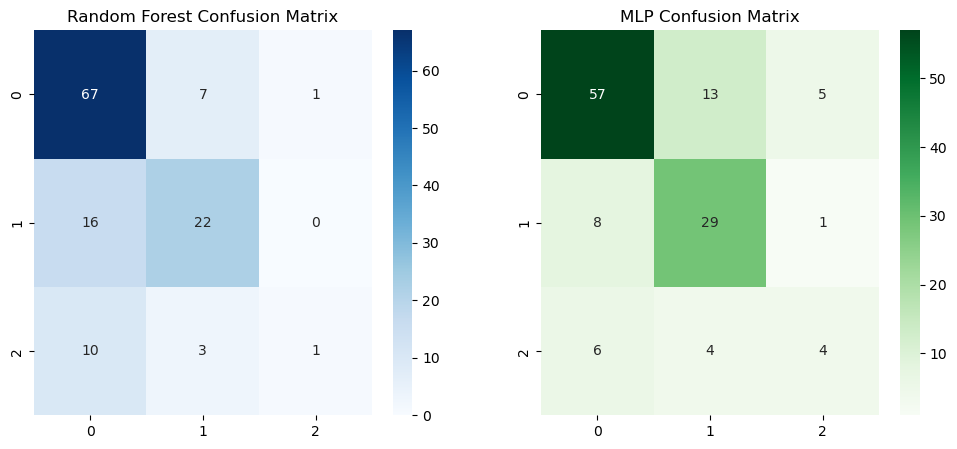

In [831]:
# Compare confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("MLP Confusion Matrix")
plt.show()

**Random Forest** is accurate for the dominant class (class 0) but struggles with the smaller or more complex ones (class 2). This indicates possible class imbalance or insufficient separation in the feature space.

The **MLP** captures more nuanced relationships between features, improving prediction of class 1 (and marginally class 2), but at the cost of slightly worse accuracy on class 0.


In [832]:

# Save processed embeddings & labels
# pivot_df.to_csv("baseline_embeddings_clusters.csv", index=False)
# print("Saved: baseline_embeddings_clusters.csv")


### Visualization
Use UMAP to reduce high-dimensional data into 2D or 3D for visualization. Helps explore data structure and possible clustering patterns.

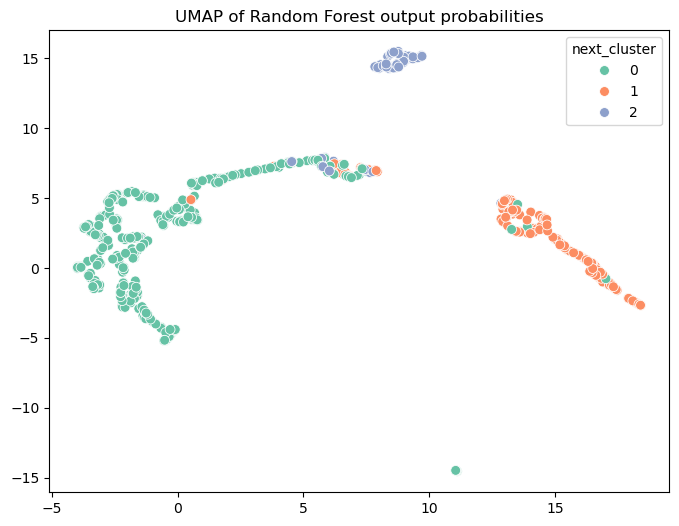

In [833]:
# Visualize Random Forest embeddings 
rf_embeddings = rf.predict_proba(X)  # soft class probabilities for each sample
Z_rf = umap.UMAP(random_state=42).fit_transform(rf_embeddings)

plt.figure(figsize=(8,6))
sns.scatterplot(x=Z_rf[:,0], y=Z_rf[:,1], hue=y, palette='Set2', s=50)
plt.title("UMAP of Random Forest output probabilities")
plt.show()

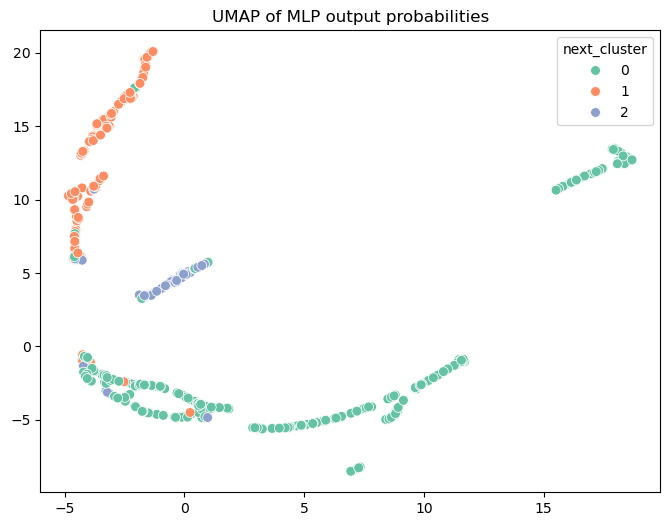

In [834]:
# Example for MLP embeddings (sklearn MLP)
mlp_embeddings = mlp.predict_proba(X)  # softmax probabilities as 4D embedding
Z_mlp = umap.UMAP(random_state=42).fit_transform(mlp_embeddings)

plt.figure(figsize=(8,6))
sns.scatterplot(x=Z_mlp[:,0], y=Z_mlp[:,1], hue=y, palette='Set2', s=50)
plt.title("UMAP of MLP output probabilities")
plt.show()

## Summary
In this notebook, we compared baseline models for predicting or classifying based on socio-economic indicators.

- **Random Forest** served as a strong baseline due to its robustness and interpretability.
- **MLP (Neural Network)** provided a non-linear alternative that may perform better if enough data is available.
- Feature scaling and proper train-test splitting ensured fair model comparison.
- Visualization steps (PCA/UMAP, confusion matrix) helped interpret model behavior and data structure.